In [1]:
import pprint
import torch

In [2]:
import pickle
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()


In [3]:
os.chdir(f"{ROOT_PATH}/hyperstyle/")

In [4]:
from utils.model_utils import load_model, load_generator
from utils.common import tensor2im

In [5]:
model_path = f"{DATA_PATH}/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt"
net, opts = load_model(model_path)
#G = load_generator(model_path)
print('Model successfully loaded!')
pprint.pprint(vars(opts))

# Get Generator
G = net.decoder

Loading HyperStyle from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt
Loading pretrained W encoder...
Loading ReStyle e4e from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/restyle/00005_snapshot_1200/checkpoints/best_model.pt
Model successfully loaded!
{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': '/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt',
 'dataset_type': 'zalando_germany_encode',
 'device': 'cuda:0',
 'encoder_type': 'SharedWeightsHyperNetResNet',
 'exp_dir': '/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/',
 'id_lambda': 0.0,
 'image_interval': 500,
 'input_nc': 6,
 'l2_lambda': 1.0,
 'layers_to_tune': '0,2,3,5,6,8,9,11,12,14,15,17,18,20,21,23,24',
 'lear

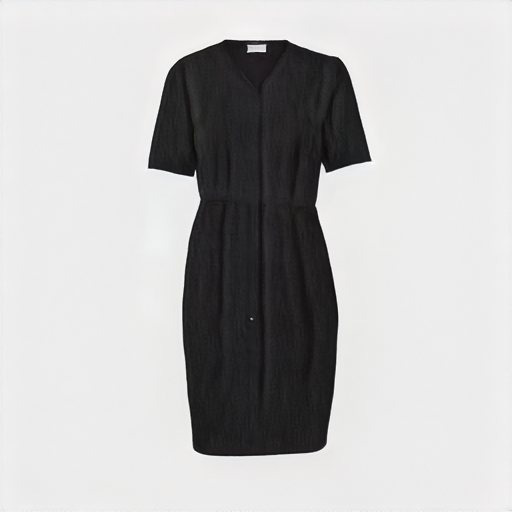

In [6]:
z = torch.randn([1, 18, 512], device = 'cuda')
img = G([z], weights_deltas=None, input_is_latent=False)[0]
tensor2im(img.squeeze(0))

In [7]:
from torch.utils.data import DataLoader
from datasets.inference_dataset import InferenceDataset
from configs import data_configs


In [8]:
dataset_args = data_configs.DATASETS[opts.dataset_type]
transforms_dict = dataset_args['transforms'](opts).get_transforms()

In [18]:
root = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/e4e_images/all"
dataset = InferenceDataset(root=root,
                               transform=transforms_dict['transform_inference'],
                               opts=opts)
dataloader = DataLoader(dataset,
                            batch_size=opts.batch_size,
                            shuffle=False,
                            num_workers=int(opts.test_workers),
                            drop_last=False)


In [10]:
import os

from tqdm import tqdm
import time
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader

import sys
sys.path.append(".")
sys.path.append("..")

from configs import data_configs
from datasets.inference_dataset import InferenceDataset
from utils.common import tensor2im
from utils.inference_utils import run_inversion
from utils.model_utils import load_model
from options.test_options import TestOptions


In [11]:
average_image = net(net.latent_avg.unsqueeze(0), input_code=True, randomize_noise=False,
                                               return_latents=False)

In [19]:
exp_dir = f'{DATA_PATH}/Generated_Images/hyperstyle/'
opts.save_weight_deltas = True
opts.n_images = len(dataset)
opts.resize_outputs = False
resize_amount = (256, 256) if opts.resize_outputs else (opts.output_size, opts.output_size)
out_path_results = os.path.join(exp_dir, 'inference_results')
out_path_coupled = os.path.join(exp_dir, 'inference_coupled')



global_i = 0
global_time = []
all_latents = {}

average_image = net(net.latent_avg.unsqueeze(0), input_code=True, randomize_noise=False,
                                               return_latents=False)

for input_batch in tqdm(dataloader):

    if global_i >= opts.n_images:
        break

    with torch.no_grad():
        input_cuda = input_batch.cuda().float()
        tic = time.time()
        result_batch, result_latents, result_deltas = run_inversion(input_cuda, net, opts,
                                                                    return_intermediate_results=True, 
                                                                    average_image = average_image)
        toc = time.time()
        global_time.append(toc - tic)

    for i in range(input_batch.shape[0]):
        results = [tensor2im(result_batch[i][iter_idx]) for iter_idx in range(opts.n_iters_per_batch)]
        im_path = dataset.paths[global_i]

        input_im = tensor2im(input_batch[i])
        res = np.array(input_im.resize(resize_amount))
        for idx, result in enumerate(results):
            res = np.concatenate([res, np.array(result.resize(resize_amount))], axis=1)
            # save individual outputs
            save_dir = os.path.join(out_path_results, str(idx))
            os.makedirs(save_dir, exist_ok=True)
            result.resize(resize_amount).save(os.path.join(save_dir, os.path.basename(im_path)))

        # save coupled image with side-by-side results
        Image.fromarray(res).save(os.path.join(out_path_coupled, os.path.basename(im_path)))

        all_latents[os.path.basename(im_path)] = result_latents[i][0]

        if opts.save_weight_deltas:
            weight_deltas_dir = os.path.join(exp_dir, "weight_deltas")
            os.makedirs(weight_deltas_dir, exist_ok=True)
            np.save(os.path.join(weight_deltas_dir, os.path.basename(im_path).split('.')[0] + ".npy"),
                    result_deltas[i][-1])

        global_i += 1

stats_path = os.path.join(opts.exp_dir, 'stats.txt')
result_str = 'Runtime {:.4f}+-{:.4f}'.format(np.mean(global_time), np.std(global_time))
print(result_str)

with open(stats_path, 'w') as f:
    f.write(result_str)

# save all latents as npy file
np.save(os.path.join(test_opts.exp_dir, 'latents.npy'), all_latents)


  0%|          | 0/1758 [00:00<?, ?it/s]

/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
  0%|          | 1/1758 [00:18<8:55:47, 18.30s/it]

: 

: 

In [ ]:
# opts.n_images = len(dataset)
# opts.resize_outputs = False

# input_batch = next(iter(dataloader))
# input_cuda = input_batch.cuda().float()
# out = net.forward(input_cuda,
#             y_hat=None,
#             codes=None,
#             weights_deltas=None,
#             return_latents=True,
#             resize=opts.resize_outputs,
#             randomize_noise=False,
#             return_weight_deltas_and_codes=True, 
#             average_image=average_image)

In [ ]:
# Check image generation
tensor2im(result_batch.squeeze(0))

In [ ]:
# Generate image from latent
gen_no_deltas = G([result_latents], 
                weights_deltas=None, 
                input_is_latent=True)[0]
tensor2im(gen_no_deltas.squeeze(0))

In [ ]:
# Generate image from latent
gen = G([result_latents], 
        weights_deltas=result_deltas, input_is_latent=True)[0]
tensor2im(gen.squeeze(0))